# Parallel: Batch Model Fitting Example

Sometimes, we might want to explore the performance of different model with a single dataset (especially with the usage of ECM with different number of RC elements). This example demonstrates how to use the `batch_model_fit` function from the `nleis.parallel` module to perform fitting of a single impedance dataset to multiple models in parallel.
This allows for efficient exploration of the model space and can lead to better model selection.

The `batch_model_fit` function allows you to specify a list of models and fits each model to the same dataset using multiple CPU cores. Same as `multistart_fit`, the `batch_model_fit` is also compatible with impedance.py natively. For detailed documentation, please refer to the [API reference](https://nleispy.readthedocs.io/en/latest/).

For simplicity and readability, we demonstrate this functionality by generating a synthetic EIS data using a porous electrode model and fitting it with the N-RC ECM, where the N spaning from 1 to 10 The same procedure can be applied to simultaneous EIS
and 2nd-NLEIS data using a `EISandNLEIS` function with `batch_model_fit` function too.

Again, we will adding random noise to the synthetic data to simulate real-world measurement conditions.

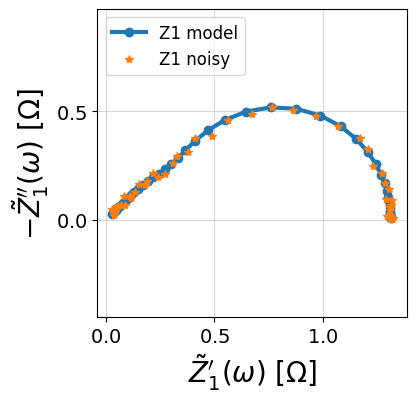

In [10]:
import numpy as np
np.random.seed(10)  # For reproducibility
import matplotlib.pyplot as plt
from impedance.models.circuits import CustomCircuit
from nleis.visualization import plot_first

circuit_1 = "TP"
model_1 = CustomCircuit(circuit_1, initial_guess=[1, 1, 1])

f = np.geomspace(1e-3, 100, 50)
Z1 = model_1.predict(f)
Z1_noise = Z1 + 0.01*(np.random.randn(len(Z1)) + 1j*np.random.randn(len(Z1)))
fig, ax = plt.subplots(figsize=(4,4))
plot_first(ax, Z1, fmt='-o', lw =3)
plot_first(ax, Z1_noise, fmt='*', lw =1)
plt.legend(['Z1 model', 'Z1 noisy'], loc=2, fontsize=12)
plt.show()

We can now import `batch_model_fit` from `nleis.parallel` module. Then we can use it to fit the model to the generated datasets in parallel.

In [11]:
from nleis.parallel import batch_model_fit

We then initialize our list of models using a loop to fit the data. Here, we create a list of N-RC ECM models with N ranging from 1 to 10.

In [12]:
model_list = []
circuit_n = "p(R1,C1)"
initial_guess = [1,1]
model_n = CustomCircuit(circuit_n, initial_guess=initial_guess)
model_list.append(model_n)
for i in range(2, 11):
    circuit_n += f"-p(R{i},C{i})"
    model_n = CustomCircuit(circuit_n, initial_guess=initial_guess*i)
    model_list.append(model_n)

We are now ready to use the `batch_model_fit` function to fit the models to the noisy synthetic data in parallel. We specify the number of CPU cores to use for parallel processing. Here, we specify `n_jobs=-1` to use all available CPU cores for parallel processing.

For this example, since we are only fitting EIS data, we only need to provide the `impedance` argument with the impedance data. If fitting both EIS and 2nd-NLEIS data, both `Z1` and `Z2` arguments need to be provided.

In [13]:
best, results = batch_model_fit(model_list, f, impedance=Z1_noise, n_jobs=-1, backend="loky", batch_size="auto")


{'idx': 0, 'Status': True, 'p0': [1, 1], 'p': array([1.27882025, 0.51869323]), 'cost': 0.39958078900331595, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x11167ccd0>}
{'idx': 1, 'Status': True, 'p0': [1, 1, 1, 1], 'p': array([0.26963563, 0.12614302, 1.04133976, 0.91268567]), 'cost': 0.0252692846193898, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x10f689210>}
{'idx': 2, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1], 'p': array([1.00360637, 0.99624886, 0.23487844, 0.28745006, 0.07525397,
       0.04269662]), 'cost': 0.006730886098533697, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x112334f10>}
{'idx': 3, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1, 1, 1], 'p': array([0.0453838 , 0.02718436, 0.10744682, 0.20076564, 0.97886424,
       1.05095084, 0.18309798, 0.63450764]), 'cost': 0.0048203704822270595, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x113fb9390>}
{'idx': 4, 'Status': True, 'p0': [1, 1, 

Similar to the `multistart_fit` function, the `batch_model_fit` function returns the best fitting model and a list of fitting results for all models. We can then analyze the fitting results to compare the performance of different models and select the best one based on criteria such as the lowest fitting cost function. For example, in this case, the best model is the 9-RC ECM model, which has the lowest fitting cost function among all models tested.

After the fitting, we can easily screening all fitting results or accessing the best fit result directly.
You will also be able to see from all runs if the fitting is converged or not. After each run, the fitting status, the initial guess, final parameters, cost value, and fitted model are stored in the dictionary.

In [14]:
best

{'idx': 9,
 'Status': True,
 'p0': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'p': array([ 0.16131226,  0.38836261,  0.06232085,  0.20143309,  0.12620053,
         8.37990421,  0.06479244, 16.32208139,  0.03974862,  0.02558268,
         0.23619652,  4.47740268,  0.30874191,  3.42534751,  0.10820064,
         2.49956488,  0.15444019,  6.84763058,  0.05342836, 19.79379587]),
 'cost': 0.0045408581223716615,
 'model': <impedance.models.circuits.circuits.CustomCircuit at 0x13f36fd10>}

The best fit model is callable and can be used to predict the impedance at any frequency. We can then plot the original noisy data, the true model, and the fitted model for comparison.


In [15]:
Z1_fit = best['model'].predict(f)

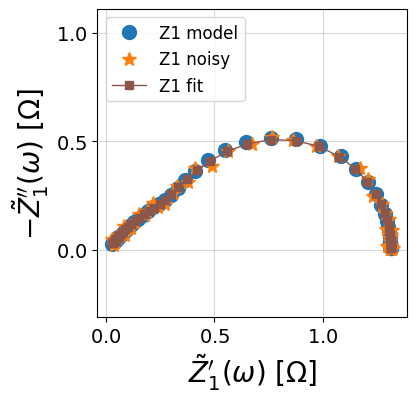

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
plot_first(ax, Z1, fmt='o', ms =10)
plot_first(ax, Z1_noise, fmt='*', ms =10, color ='C1')
plot_first(ax, Z1_fit, fmt='-s', lw =1, color ='C5')
plt.legend(['Z1 model', 'Z1 noisy', 'Z1 fit'], loc=2, fontsize=12)
plt.ylim([0,0.8])
plt.show()

Maybe we will also be interested to see the worset fitting result among all models tested. We can access it easily from the results list by finding the model with the highest cost function value.

In [17]:
worst_result = max(results, key=lambda x: x['cost'])
print(worst_result)

{'idx': 0, 'Status': True, 'p0': [1, 1], 'p': array([1.27882025, 0.51869323]), 'cost': 0.39958078900331595, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x13f855b50>}


It is perhaps not surprising that the worst fitting model is the 1-RC ECM model, which is know to not be able to capture the porous electrode response of the system accurately. We can also plot the worst fitting result for comparison.

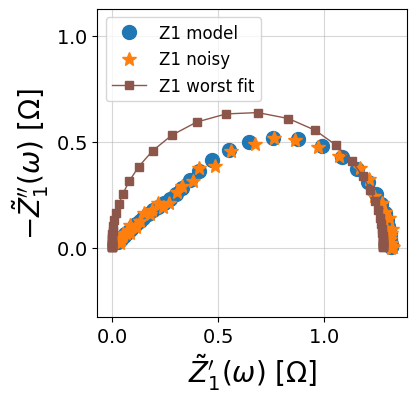

In [18]:
Z1_fit_worst = worst_result['model'].predict(f)
fig, ax = plt.subplots(figsize=(4,4))
plot_first(ax, Z1, fmt='o', ms =10)
plot_first(ax, Z1_noise, fmt='*', ms =10, color ='C1')
plot_first(ax, Z1_fit_worst, fmt='-s', lw =1, color ='C5')
plt.legend(['Z1 model', 'Z1 noisy', 'Z1 worst fit'], loc=2, fontsize=12)
plt.ylim([0,0.8])
plt.show()